## Final Setup

The idea is to reach a target ie 99.4% test accracy in 15 epochs

### Pipeline 
1. Data Loader abstracted to use separate augmentation file
2. Model moved to a separate file
3. Add Data Visualization module for Dataset and Incorrect Prediction

### Targets
1. Further improve accuracy to reach above **99.4%** in 15 epochs
2. Use Custom OneCycleLR to train model
3. Use Augmentation to add Regularization to Network

### Results
1. Retrained network with **3,762** params
2. Trained for 15 Epochs and reached an accuracy of **98.94%** Train and **99.43%** Test

### Analysis
1. We can clearly see the effect of using Transformation and OneCycleLR
2. We can still see there are some images that are getting miss classified these are the ones that even humans can not distinguish
3. We can still train our network further with a better training schedule

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
from __future__ import print_function

In [7]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)

batch_size = 32
class_map = {
    'ZERO': 0,
    'ONE': 1,
    'TWO': 2,
    'THREE': 3,
    'FOUR': 4,
    'FIVE': 5,
    'SIX': 6,
    'SEVEN': 7,
    'EIGHT': 8,
    'NINE': 9
}
show_summary = True
show_dataset_analyze = False

In [8]:
# Load Network and Print Summary
from mnist.model import Net
from mnist.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()

if show_summary:
    model = Net(norm='bn').to(device)
    print_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3            [-1, 4, 28, 28]             148
       BatchNorm2d-4            [-1, 4, 28, 28]               8
            Conv2d-5            [-1, 4, 28, 28]             148
       BatchNorm2d-6            [-1, 4, 28, 28]               8
         MaxPool2d-7            [-1, 4, 14, 14]               0
           Dropout-8            [-1, 4, 14, 14]               0
            Conv2d-9            [-1, 8, 14, 14]             296
      BatchNorm2d-10            [-1, 8, 14, 14]              16
           Conv2d-11            [-1, 8, 14, 14]             584
      BatchNorm2d-12            [-1, 8, 14, 14]              16
           Conv2d-13            [-1, 8, 14, 14]             584
      BatchNorm2d-14            [-1, 8,

In [9]:
from mnist.dataset import get_loader
from mnist.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader(get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

In [10]:
## Calculate Class Scale
from mnist.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    print_class_scale(train_loader, class_map)
    print_samples(train_loader)

In [15]:
import time
import math

from mnist.backpropagation import train, test, get_sgd_optimizer
from mnist.utils import initialize_weights
from mnist.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from mnist.training import Training

# Train Params
epochs = 15
lr = 0.05
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = True
momentum = 0.9
weight_decay = 0

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

model = Net(norm='bn').apply(initialize_weights).to(device)
optimizer = get_sgd_optimizer(model, lr=lr)

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

# One cycle schedule with a custom function
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

trainer = Training(
    model,
    optimizer,
    custom_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()

Using Device: cuda
Epochs: 15
Lr: 0.05
Max Lr: 0.1
Batch Size: 32
Dropout: True


| Epoch | LR       | Time    | TrainLoss | TrainCorrect | TrainAcc | ValLoss  | ValCorrect | ValAcc |
|     1 | 0.050000 | 00m 14s | 0.347041  |        53292 | 88.82  % | 0.075873 |       9760 | 97.6 % |
|     2 | 0.075000 | 00m 16s | 0.133324  |        57619 | 96.03  % | 0.066363 |       9797 | 97.97% |
|     3 | 0.100000 | 00m 15s | 0.107717  |        58053 | 96.75  % | 0.045474 |       9849 | 98.49% |
|     4 | 0.085000 | 00m 16s | 0.076225  |        58673 | 97.79  % | 0.042818 |       9858 | 98.58% |
|     5 | 0.070000 | 00m 17s | 0.06339   |        58873 | 98.12  % | 0.032771 |       9898 | 98.98% |
|     6 | 0.055000 | 00m 16s | 0.052222  |        59032 | 98.39  % | 0.027366 |       9909 | 99.09% |
|     7 | 0.040000 | 00m 14s | 0.049818  |        59070 | 98.45  % | 0.022665 |       9935 | 99.35% |
|     8 | 0.025000 | 00m 15s | 0.042174  |        59207 | 98.68  % | 0.021440 |       9936 | 99.36% |


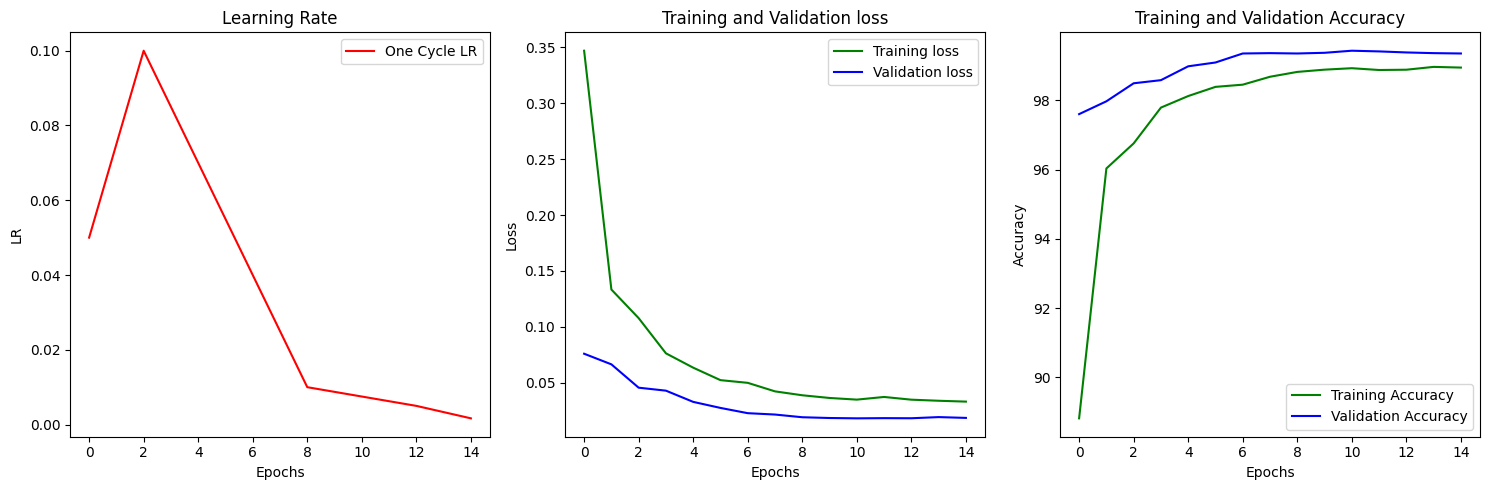

In [16]:
from mnist.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

## Analyze Network

Confusion matrix, without normalization


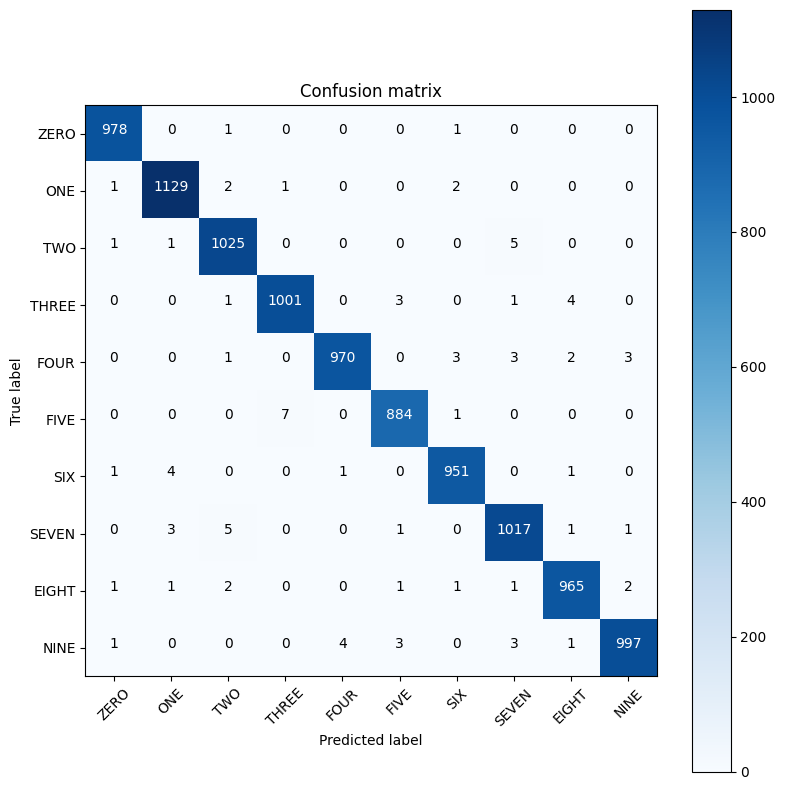

In [13]:
from mnist.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from mnist.visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)

Total Incorrect Predictions 83


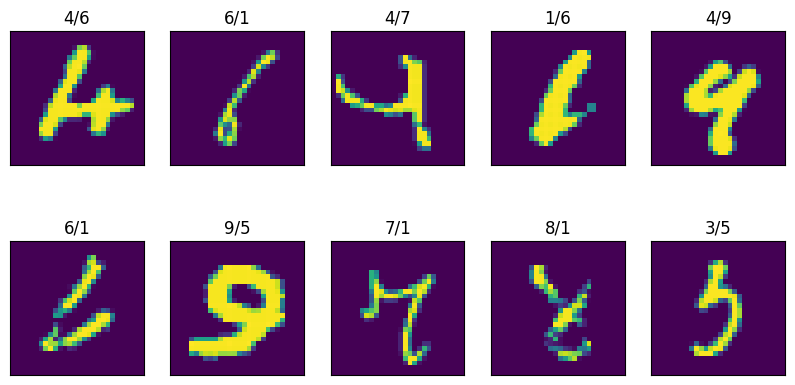

In [14]:
from mnist.utils import get_incorrrect_predictions
from mnist.visualize import plot_incorrect_predictions

incorrect = get_incorrrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)